In [162]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from text_clean import *


import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import pandas as pd

analyser = SentimentIntensityAnalyzer()

def label_stocks(row):
    if row['Close'] >= row['yesterday_close']:
        return 1
    else:
      return 0

def label_sentiment(row):
    sent = analyser.polarity_scores(row['text'])
    return pd.Series([sent['neg'], sent['neu'], sent['pos'], sent['compound']])

    

# File paths
apple_stocks = "Data/Stock data/Stocks/aapl.us.txt"
amazon_stocks = "Data/Stock data/Stocks/amzn.us.txt"
facebook_stocks = "Data/Stock data/Stocks/fb.us.txt"

apple_headlines = "Data/News data/apple_deduped.csv"
amazon_headlines = "Data/News data/amazon_deduped.csv"
facebook_headlines = "Data/News data/facebook_deduped.csv"

apple_reddit = "Data/News data/apple_reddit.csv"
amazon_reddit = "Data/News data/amazon_reddit.csv"
facebook_reddit = "Data/News data/facebook_reddit.csv"

apple_tweets = "Data/Tweets/apple_tweets.csv"
amazon_tweets = "Data/Tweets/amazon_tweets.csv"
facebook_tweets = "Data/Tweets/facebook_tweets.csv"

# Twitter date parser
mydateparser = lambda x: pd.datetime.strptime(x[:10] + " " + x[-4:], "%a %b %d %Y")

# Read in text data and stock data
df = pd.read_csv('Data/Tweets/apple_tweets.csv', parse_dates=[1], date_parser=mydateparser)
df[['neg', 'neu', 'pos', 'compound']] =  df.apply(label_sentiment, axis=1)
# df = pd.read_csv(apple_headlines, parse_dates=[1])
stock = pd.read_csv('aapl_indicators.us.txt', parse_dates=[0])
stock['yesterday_close'] = stock['Close'].shift()
stock['value'] = stock.apply(lambda row: label_stocks(row), axis=1)

stock.loc[:, 'High':'yesterday_close'] = stock.loc[:, 'High':'yesterday_close'].shift()

In [163]:
# Rename twitter columns if necessary
# df.rename({'created_at': 'Date'}, inplace=True, axis=1)

df = pd.merge(df, stock, on="Date", how="inner")
df.drop('Close', axis=1, inplace=True)

"""
BALANCE CLASSES
"""
# Class count
count_class_1, count_class_0 = df.value.value_counts()

# Divide by class
df_class_0 = df[df['value'] == 0]
df_class_1 = df[df['value'] == 1]

if count_class_1 > count_class_0:
    df_class_1_under = df_class_1.sample(count_class_0)
    df = pd.concat([df_class_1_under, df_class_0], axis=0)
else:
    df_class_0_under = df_class_0.sample(count_class_1)
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    

df = df.set_index(['Date'])
df.sort_index(inplace=True)

In [164]:
scaler = MinMaxScaler()
df.loc[:, 'neg': 'yesterday_close'] = scaler.fit_transform(df.loc[:, 'neg': 'yesterday_close'])

Preprocess and split data into train and test sets

In [165]:
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x.loc[:, 'neg': 'yesterday_close'], validate=False)

df['text'] = df['text'].str.replace('[^\w\s]',' ')

vect = TfidfVectorizer(analyzer=preprocess_text, strip_accents='unicode', ngram_range=(1, 3))

#X = features, y = class labels
X = df.loc[:, 'text': 'yesterday_close']
y = df.loc[:, 'value']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Avoid having same days in train and test set
X_train, y_train = shuffle(X.loc[:'2015-07-26'], y.loc[:'2015-07-26'])
X_test, y_test = shuffle(X.loc['2015-07-27':], y.loc['2015-07-27':])

In [167]:
model = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data)
            ])),
               ('text_features', Pipeline([
                  ('selector', get_text_data),
                  ('vec',  vect)
              ]))
         ])),
    ('clf', LinearSVC(class_weight='balanced', max_iter=3000, penalty='l1', dual=False)),
    #('clf', KNeighborsClassifier(n_neighbors=3)),
    #('clf', LinearSVC(class_weight='balanced', fit_intercept=False, penalty='l1', dual=False, C=0.1)),
])

model.fit(X_train, y_train)
print(model.score(X_train, y_train))
y_pred = model.predict(X_test)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

0.9672332811451577
Accuracy: 49.41%

F1 Score: 53.52

Confusion Matrix:
 [[583 986]
 [468 837]] 



In [122]:
X_train

,text,user_id_str,Open,High,Low,Volume,volume_adi,volume_obv,volume_obvm,volume_cmf,...,momentum_ao,others_dr,others_dlr,others_cr,yesterday_close,value,neg,neu,pos,compound
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-23,damn missed that quick jump in aapl,524732173,1.086333,0.991797,0.937092,1.696881,0.768493,-1.649690,-0.236326,0.260473,...,0.200181,-2.498388,-2.537200,1.047080,1.340670,-1.0,5.928519,-3.085857,-0.672054,-2.407151
2015-03-10,rt AT_USER usg black budget for subverting end...,19245752,1.070086,1.178913,1.075073,0.834701,-1.090524,1.257769,0.118585,1.023907,...,1.157119,0.221828,0.229297,1.120744,1.090518,-1.0,-0.449283,0.845038,-0.672054,-0.284774
2015-01-27,aapl will rise ah only if best estimates not...,465618822,0.300893,0.352714,0.390277,-0.233070,-0.344718,0.789898,0.661723,-0.077952,...,-0.245046,0.032975,0.041401,0.346991,0.341187,-1.0,-0.449283,-1.379713,1.959604,1.736371
2014-09-09,rt AT_USER wall street cheers then kinda sours...,66775682,-0.428805,-0.461102,-0.425801,-0.529220,-0.200583,-0.674268,0.006017,0.189255,...,0.234627,-0.385177,-0.376793,-0.460162,-0.425869,-1.0,-0.449283,-0.372562,0.768245,1.227991
2014-04-23,aapl earnings preview URL,904243855,-1.711223,-1.723942,-1.690176,-0.369063,1.399999,0.730310,0.248737,0.449935,...,-0.542764,0.035322,0.043739,-1.689618,-1.688459,-1.0,-0.449283,0.845038,-0.672054,-0.284774
2014-12-08,epgl tick click here URL also see ntek...,2197078218,0.389969,0.442664,0.488510,-0.797843,-0.885895,-0.556564,-0.772055,0.735693,...,0.873962,-0.273904,-0.265217,0.448771,0.474676,-1.0,-0.449283,0.845038,-0.672054,-0.284774
2014-07-29,new post positions update july 29 aapl w...,237994484,-0.441466,-0.490474,-0.478495,-0.226268,1.205087,0.792879,0.178613,0.961788,...,0.443768,0.789859,0.790838,-0.450997,-0.520264,-1.0,-0.449283,0.085917,0.225910,0.357207
2015-04-13,rt AT_USER apple watch first weekend numbers u...,2715475950,1.173728,1.053984,1.085862,-0.741512,1.106739,0.567111,-0.137402,0.074249,...,-0.410794,0.221909,0.229377,1.118494,1.088275,-1.0,1.001880,-0.049372,-0.672054,-1.560168
2014-06-13,aapl google and apple fight for your heart...,1691494189,-0.816034,-0.757046,-0.779442,-0.244684,-0.926774,-0.798944,-0.369889,1.157474,...,1.222789,-1.003700,-1.000913,-0.805989,-0.720553,-1.0,3.416421,-1.537551,-0.672054,-2.689902


# Graph most influential words:

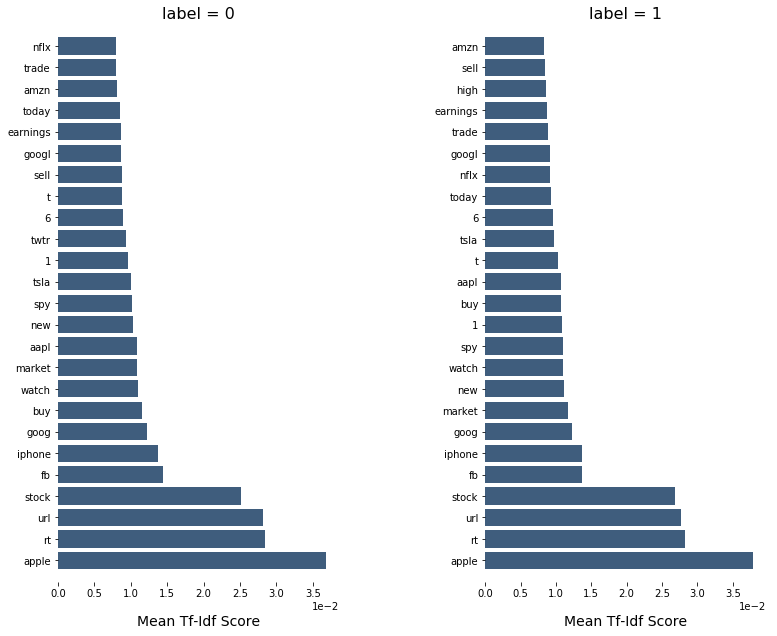

In [62]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

# model.named_steps['features'].transformer_list[1][1].named_steps['vec']
Xtr = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].fit_transform(X['text'])
features = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].get_feature_names()
feats = top_feats_by_class(Xtr, y, features)

plot_tfidf_classfeats_h(feats)

In [ ]:
# Time Series split?
X = df.loc[:, 'text': 'yesterday_close']
y = df['value']
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    print("Y_TRAIN")
    print(y_train)
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print("Y_TEST")
    print(y_test)

# Plot ROC Curve along with other stats

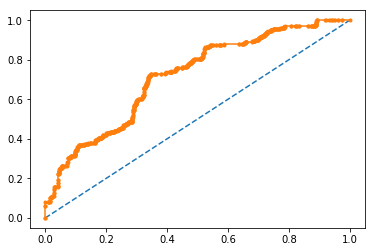

In [86]:
from sklearn.metrics import classification_report, roc_auc_score
from matplotlib import pyplot

def evaluate(classifier):
    predicted = classifier.predict(X_test)
    if isinstance(classifier.steps[1][1], LinearSVC):
        probabilities = np.array(classifier.decision_function(X_test))
        scores = probabilities
    else:
        probabilities = np.array(classifier.predict_proba(X_test))
        scores = probabilities[:, 1]  # NEW

    testing_category_array = np.array(y_test)  # NEW
    pos_idx = np.where(testing_category_array == 1)
    predicted_true_binary = np.zeros(testing_category_array.shape)
    predicted_true_binary[pos_idx] = 1
    fpr, tpr, thresholds = roc_curve(predicted_true_binary, scores)
    auc = roc_auc_score(predicted_true_binary, scores)

    mean_acc = np.mean(predicted == y_test)
    report = classification_report(y_test, predicted)

    return fpr, tpr, auc, mean_acc, report

fpr, tpr, auc, mean_acc, report = evaluate(model)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [87]:
auc

0.7183168709413081

In [ ]:
# Figure out how to graph SVM
svd = TruncatedSVD(n_components=2, random_state=42)
transformed = svd.fit_transform(model.named_steps["debug"].data)
principalDf = pd.DataFrame(data = transformed
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['value']]], axis = 1)